<a href="https://colab.research.google.com/github/ahmedmusawir/langgraph-101-youtube-series/blob/main/LANGGRAPH_BASIC_PART_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

### INSTALLATIONS

In [ ]:
!pip install -q langchain
!pip install -q langchain_community
!pip install -q langgraph

!pip install -q langchain_openai
!pip install -q langchain-anthropic
!pip install -q langchain-groq
!pip install -q langchain-google-genai

!pip show langchain
!pip show langgraph



Name: langchain
Version: 0.3.14
Summary: Building applications with LLMs through composability
Home-page: https://github.com/langchain-ai/langchain
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: aiohttp, async-timeout, langchain-core, langchain-text-splitters, langsmith, numpy, pydantic, PyYAML, requests, SQLAlchemy, tenacity
Required-by: langchain-community
Name: langgraph
Version: 0.2.62
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-sdk
Required-by: 


### LOADING API KEY

In [ ]:
import os
os.environ["OPENAI_API_KEY"] ="sk-proj-ulX3zMWA*************KFU8CUAYWg7y8Ge8pROt"
os.environ["ANTHROPIC_API_KEY"]="sk-ant-api03-S*******s4bmmTp3hDmAaVang-IsYoZAAA"
os.environ["GOOGLE_API_KEY"] ="AIzaSyCKnwHrSc*******************cuoMTJMtvzSDmziA"
os.environ["GROQ_API_KEY"] ="gsk_DIdLqIGij05lGx2b7sqj******W5XXVUtlxWcRRXwc3EDrc"


os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LANGGRAPH TUTORIAL 100 SERIES"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "lsv2_pt_4ce94482082c445888722****c_37d096d1b5"

# LangGraph 102 - Adding Tool Node and Conditional Edge

## STEP 1: Loading the Imports

In [ ]:
from typing import Annotated, Literal
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI


## STEP 2: Initiatiate the Graph

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph = StateGraph(State)

## STEP 3: Creating the Tools

In [ ]:
@tool
def get_weather(location: str):
    """Call to get the current weather. Use the response of this tool verbatim.
    Use this anytime asked about the current weather"""

    if location.lower() in ["new york"]:
        return "It's cold and wet."
    else:
        return "It's warm and sunny."

@tool
def get_ai_status(company: str):
    """Call to get the current AI status. Use the response of this tool verbatim.
    Use this anytime asked about the current status of AI of a company."""

    if company.lower() == "google":
        return "Gemini is pretty awful."
    else:
        return "Overall AI status is good!"

tools = [get_weather, get_ai_status]

# result = get_ai_status("google")
# result

## STEP 4: Building the LLM w/ Tools & Adding the Tools Node to Graph

In [ ]:
# Creating the LLM with an Openai Model
llm = ChatOpenAI(model="gpt-4o")

# Binding the LLM with Tools
llm_with_tools = llm.bind_tools(tools)

# Createing the Tool Node
tool_node = ToolNode(tools)

# Adding the Tool Node to Our Graph
graph.add_node("tool_node", tool_node)

## STEP 5: Creating & Adding the Main Node to Graph

In [ ]:
# defining the prompt_node
def prompt_node(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# adding the node to the graph
graph.add_node("prompt_node", prompt_node)

## STEP 6: Creating the Conditional Edge & Adding the Edges to Graph

In [ ]:
# Defining the Conditional Edge
def conditional_edge(state: State) -> Literal['tool_node', '__end__']:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tool_node"
    else:
        return "__end__"

# Adding the Conditional Edge to Our Graph
graph.add_conditional_edges(
    'prompt_node',
    conditional_edge
)

# Adding the Normal Edge
graph.add_edge("tool_node", "prompt_node")

# Setting the Starting Point of Our Graph
graph.set_entry_point("prompt_node")

# graph = graph.compile()
# graph

## STEP 7: Add Conversional Memory & Compile Graph

In [ ]:
!pip install -q langgraph-checkpoint-sqlite

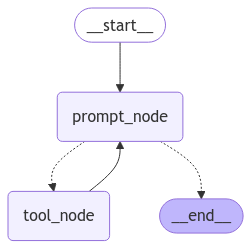

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.memory import MemorySaver

memory = SqliteSaver.from_conn_string(':memory:')
graph = graph.compile(checkpointer=MemorySaver()) # ADDING MEMORY

graph

## STEP 8: Chat With Your Graph

In [ ]:
while True:

    user_input = input('User: ')
    if user_input.lower() in ['quit', 'exit', 'bye',  'q']:
        print('Goodbye!')
        break

    config = {'configurable': {'thread_id': '1'}}

    response = graph.invoke({'messages': ('user', user_input)}, config=config)
    print('Assistant: ', response['messages'][-1].content)
    print('-' * 50)

User: Hi I am moose from atlanta
Assistant:  Hello Moose from Atlanta! How can I assist you today?
--------------------------------------------------
User: what is the ai status of google
Assistant:  The AI status of Google is: "Gemini is pretty awful." If you have any other questions or need more information, feel free to ask!
--------------------------------------------------
User: ai status of openai?
Assistant:  The AI status of OpenAI is: "Overall AI status is good!" If you have more inquiries or need further details, just let me know!
--------------------------------------------------
User: current weather of new york?
Assistant:  The current weather in New York is cold and wet. If there's anything else you need, feel free to ask!
--------------------------------------------------
User: current weather of paris?
Assistant:  The current weather in Paris is warm and sunny. If you need more information, just let me know!
--------------------------------------------------
User: Tell 